In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import obonet
from collections import Counter
import seaborn as sns

# Get raw data

## Read files

In [2]:
# replace and lower
def relo(name):
    tmp = name.lower().replace('-', ' ').replace('/', ' ').replace(',', '').split(' ')
    tmp.sort()
    return tuple(tmp)

In [3]:
lncRNADisease_all = pd.read_excel('data/other datasets/LncRNADisease v2.0/experimental lncRNA-disease information.xlsx')
# lncRNADisease_experimental = lncRNADisease_all[(lncRNADisease_all['Species'] == 'Homo sapiens') & (lncRNADisease_all['ncRNA Category'] == 'lncRNA')][['ncRNA Symbol', 'Disease Name', 'Sample', 'Dysfunction Pattern', 'Validated Method', 'Description', 'PubMed ID']]
lnc_di_lncRNADisease_v2 = pd.DataFrame(lncRNADisease_all[(lncRNADisease_all['Species'] == 'Homo sapiens') & (lncRNADisease_all['ncRNA Category'] == 'lncRNA')][['ncRNA Symbol', 'Disease Name']].values, columns=['lncRNA', 'disease']).drop_duplicates()
lnc_di_lncRNADisease_v2.insert(2, 'lower disease name', '')
for idx, row in lnc_di_lncRNADisease_v2.iterrows():
    row['lower disease name'] = relo(row['disease'])
lnc_di_lncRNADisease_v2

,lncRNA,disease,lower disease name
0,116HG,Prader-Willi syndrome,"(prader, syndrome, willi)"
1,17A,Alzheimer's disease,"(alzheimer's, disease)"
2,1B FGF-antisense transcripts,endometriosis,"(endometriosis,)"
3,21A,astrocytoma,"(astrocytoma,)"
4,21A,cancer,"(cancer,)"
...,...,...,...
9997,ZNRD1ASP,cervical cancer,"(cancer, cervical)"
9998,ZNRD1ASP,endometrial carcinoma,"(carcinoma, endometrial)"
9999,ZNRD1ASP,hepatocellular carcinoma,"(carcinoma, hepatocellular)"
10000,ZNRD1ASP,lung cancer,"(cancer, lung)"


In [4]:
lncRNA2Cancer_all = pd.read_excel('data/other datasets/lnc2Cancer v3.0/lncRNA.xlsx')
lnc_di_lnc2Cancer_v3 = pd.DataFrame(lncRNA2Cancer_all[['name', 'cancer type']].values, columns=['lncRNA', 'disease']).drop_duplicates()
lnc_di_lnc2Cancer_v3.insert(2, 'lower disease name', '')
for idx, row in lnc_di_lnc2Cancer_v3.iterrows():
    row['lower disease name'] = relo(row['disease'])
lnc_di_lnc2Cancer_v3

,lncRNA,disease,lower disease name
0,LINC001152,hepatocellular carcinoma,"(carcinoma, hepatocellular)"
1,LINC00152,cervical cancer,"(cancer, cervical)"
2,6p22lncRNAs,neuroblastoma,"(neuroblastoma,)"
3,7SK,hepatocellular carcinoma,"(carcinoma, hepatocellular)"
4,7SL,breast cancer,"(breast, cancer)"
...,...,...,...
9248,ZNRD1-AS1,endometrial cancer,"(cancer, endometrial)"
9249,ZNRD1-AS1,lung cancer,"(cancer, lung)"
9250,ZXF1,lung adenocarcinoma,"(adenocarcinoma, lung)"
9252,ZXF2,gastric cancer,"(cancer, gastric)"


In [5]:
HMDD_all = pd.read_excel('data/other datasets/HMDD v3.2/alldata.xlsx')
mi_di_HMDD_v3 = pd.DataFrame(HMDD_all[['mir', 'disease']].values, columns=['miRNA', 'disease']).drop_duplicates()
mi_di_HMDD_v3.insert(2, 'lower disease name', '')
for idx, row in mi_di_HMDD_v3.iterrows():
    if row['disease'][-13:] == ' [unspecific]':
        row['disease'] = row['disease'][:-13]
    row['lower disease name'] = relo(row['disease'])
mi_di_HMDD_v3

,miRNA,disease,lower disease name
0,hsa-mir-15a,"Leukemia, Lymphocytic, Chronic, B-Cell","(b, cell, chronic, leukemia, lymphocytic)"
1,hsa-mir-16,"Leukemia, Lymphocytic, Chronic, B-Cell","(b, cell, chronic, leukemia, lymphocytic)"
2,hsa-mir-143,Colon Neoplasms,"(colon, neoplasms)"
3,hsa-mir-145,Colon Neoplasms,"(colon, neoplasms)"
4,hsa-mir-223,"Leukemia, Lymphocytic, Chronic, B-Cell","(b, cell, chronic, leukemia, lymphocytic)"
...,...,...,...
35541,hsa-mir-301b,Neoplasms,"(neoplasms,)"
35542,hsa-mir-3648,Neoplasms,"(neoplasms,)"
35543,hsa-mir-3687,Neoplasms,"(neoplasms,)"
35544,hsa-mir-4746,Neoplasms,"(neoplasms,)"


In [6]:
starBase = pd.read_csv('data/other datasets/starBase/starBase_Human_Pan-Cancer_miRNA-LncRNA_Interactions.csv')[['mirAccession', 'geneName']].drop_duplicates()
miRBase = pd.read_excel('data/other datasets/miRBase/miRNA.xls')[['ID', 'Mature1_Acc', 'Mature2_Acc']]

mi_lnc_starBase = pd.DataFrame(columns=['miRNA', 'lncRNA'])
for idx, row in starBase.iterrows():
    for id in miRBase[miRBase['Mature1_Acc'] == row['mirAccession']]['ID'].values:
        mi_lnc_starBase = mi_lnc_starBase.append({'miRNA': id, 'lncRNA': row['geneName']}, ignore_index=True)
    for id in miRBase[miRBase['Mature2_Acc'] == row['mirAccession']]['ID'].values:
        mi_lnc_starBase = mi_lnc_starBase.append({'miRNA': id, 'lncRNA': row['geneName']}, ignore_index=True)
mi_lnc_starBase

,miRNA,lncRNA
0,hsa-mir-200b,CTA-204B4.6
1,hsa-mir-200b,CTD-2630F21.1
2,hsa-mir-200b,CTB-92J24.2
3,hsa-mir-200b,RP11-473I1.10
4,hsa-mir-200b,AC005154.5
...,...,...
11867,hsa-mir-224,RP11-186B7.4
11868,hsa-mir-224,MALAT1
11869,hsa-mir-224,CTD-2528L19.6
11870,hsa-mir-224,SRRM2-AS1


In [10]:
# attention! vpn is needed.
url = 'https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/main/src/ontology/doid.obo'
HDO_Net = obonet.read_obo(url)

## Change the data structure

In [11]:
DOID = list(HDO_Net.nodes)
p = re.compile(r'["](.*?)["]', re.S)
DOID_Name_synonym = {}
for doid in DOID:
    do_tmp = {
        'name': '',
        'synonym': set()
    }
    do_tmp['name'] = relo(HDO_Net.nodes[doid]['name'])    # no '-', all lower!!!
    if 'synonym' in HDO_Net.nodes[doid].keys():
        for synonym in HDO_Net.nodes[doid]['synonym']:
            do_tmp['synonym'].add(relo(re.findall(p, synonym)[0]))    # no '-', all lower!!!
    DOID_Name_synonym[doid] = do_tmp
# {
#     DOID: {
#         'name': ,
#         'synonym': {}
#     }
# }

In [12]:
mesh_D = {}
with open('data/other datasets/MeSH/d2022.bin', 'r', encoding='UTF-8') as f:
    for row in f:
        row = row.strip()
        if row == '*NEWRECORD':
            mesh_tmp = {
                'Entry Terms': set()
            }
        if row[:4] == 'MH =':
            mesh_tmp['name'] = row[5:]
            mesh_tmp['MeSH Heading'] = relo(row[5:]) # no '-', all lower!!!
        if row[:11] == 'PRINT ENTRY':
            mesh_tmp['Entry Terms'].add(relo(row[14:].split('|')[0])) # no '-', all lower!!!
        if row[:5] == 'ENTRY':
            mesh_tmp['Entry Terms'].add(relo(row[8:].split('|')[0]))  # no '-', all lower!!!
        if row[:2] == 'UI':
            mesh_D[row[5:]] = mesh_tmp
# {
#     MeSH_ID: {
#         'name': ,
#         'MeSH Heading': ,
#         'Entry Terms': {}
#     }
# }

In [13]:
DO_MeSH = pd.DataFrame(columns=['DOID', 'MeSH ID'])
for doid in DOID:
    if 'xref' in HDO_Net.nodes[doid].keys():
        xrefs = HDO_Net.nodes[doid]['xref']
        for xref in xrefs:
            if xref[:4] == 'MESH':
                DO_MeSH = DO_MeSH.append({'DOID': doid, 'MeSH ID': xref[5:]}, ignore_index=True)

In [10]:
DO_MeSH

,DOID,MeSH ID
0,DOID:0001816,D006394
1,DOID:0014667,D008659
2,DOID:0040091,D000081012
3,DOID:0050061,D004887
4,DOID:0050118,D004670
...,...,...
3592,DOID:998,D016603
3593,DOID:9986,C537131
3594,DOID:9988,D009494
3595,DOID:999,D004802


# get disease nodes

## auto

In [14]:
di_lnc2Cancer_v3 = lnc_di_lnc2Cancer_v3[['disease', 'lower disease name']].dropna().drop_duplicates(subset=['lower disease name'])
di_lnc2Cancer_v3.columns = ['lnc2Cancer cancer type', 'lower disease name']
display(di_lnc2Cancer_v3)

,lnc2Cancer cancer type,lower disease name
0,hepatocellular carcinoma,"(carcinoma, hepatocellular)"
1,cervical cancer,"(cancer, cervical)"
2,neuroblastoma,"(neuroblastoma,)"
4,breast cancer,"(breast, cancer)"
5,colorectal cancer,"(cancer, colorectal)"
...,...,...
8698,epithelial squamous carcinoma,"(carcinoma, epithelial, squamous)"
8701,hypopharyngeal carcinoma,"(carcinoma, hypopharyngeal)"
8956,renal collecting duct carcinoma,"(carcinoma, collecting, duct, renal)"
8958,female embryonal carcinoma,"(carcinoma, embryonal, female)"


In [15]:
di_lncRNADisease_v2 = lnc_di_lncRNADisease_v2[['disease', 'lower disease name']].dropna().drop_duplicates(subset=['lower disease name'])
di_lncRNADisease_v2.columns = ['lncRNADisease Disease name', 'lower disease name']
display(di_lncRNADisease_v2)

,lncRNADisease Disease name,lower disease name
0,Prader-Willi syndrome,"(prader, syndrome, willi)"
1,Alzheimer's disease,"(alzheimer's, disease)"
2,endometriosis,"(endometriosis,)"
3,astrocytoma,"(astrocytoma,)"
4,cancer,"(cancer,)"
...,...,...
9221,denatured dermis,"(denatured, dermis)"
9230,Klinefelter's syndrome,"(klinefelter's, syndrome)"
9296,Helicobacter pylori,"(helicobacter, pylori)"
9920,Colonic Neoplasms,"(colonic, neoplasms)"


In [14]:
auto_diseases = pd.DataFrame(columns=['DOID', 'Name', 'matching way', 'intermediary', 'lower disease name', 'lnc2Cancer cancer type', 'lncRNADisease Disease name']) 
tmp_auto_diseases = di_lnc2Cancer_v3.merge(di_lncRNADisease_v2, on='lower disease name',how='outer')
for index, row in tmp_auto_diseases.iterrows():
    flag = True
    for doid in DOID_Name_synonym:
        tmp = DOID_Name_synonym[doid]
        if (row['lower disease name'] == tmp['name']):
            auto_diseases = auto_diseases.append({
                'DOID': doid,
                'Name': HDO_Net.nodes[doid]['name'],
                'matching way': 'direct',
                'lower disease name': row['lower disease name'],
                'lnc2Cancer cancer type': row['lnc2Cancer cancer type'],
                'lncRNADisease Disease name': row['lncRNADisease Disease name']
            }, ignore_index=True)
            flag = False
    if flag:
        for doid in DOID_Name_synonym:
            tmp = DOID_Name_synonym[doid]
            if (row['lower disease name'] in tmp['synonym']):
                auto_diseases = auto_diseases.append({
                    'DOID': doid,
                    'Name': HDO_Net.nodes[doid]['name'],
                    'matching way': 'synonym',
                    'lower disease name': row['lower disease name'],
                    'lnc2Cancer cancer type': row['lnc2Cancer cancer type'],
                    'lncRNADisease Disease name': row['lncRNADisease Disease name']
                }, ignore_index=True)
                flag = False
    if flag:
        for meshid in mesh_D:
            tmp = mesh_D[meshid]
            if (row['lower disease name'] == tmp['MeSH Heading']):
                tmp_DO_MeSH = DO_MeSH[DO_MeSH['MeSH ID'] == meshid]
                if not tmp_DO_MeSH.empty:
                    for tmp_DO_MeSH_value in tmp_DO_MeSH['DOID'].values:
                        auto_diseases = auto_diseases.append({
                            'DOID': tmp_DO_MeSH_value,
                            'Name': HDO_Net.nodes[tmp_DO_MeSH_value]['name'],
                            'matching way': 'mesh',
                            'intermediary': mesh_D[meshid]['name'],
                            'lower disease name': row['lower disease name'],
                            'lnc2Cancer cancer type': row['lnc2Cancer cancer type'],
                            'lncRNADisease Disease name': row['lncRNADisease Disease name']
                        }, ignore_index=True)
                        flag = False
    if flag:
        for meshid in mesh_D:
            tmp = mesh_D[meshid]
            if (row['lower disease name'] in tmp['Entry Terms']):
                tmp_DO_MeSH = DO_MeSH[DO_MeSH['MeSH ID'] == meshid]
                if not tmp_DO_MeSH.empty:
                    for tmp_DO_MeSH_value in tmp_DO_MeSH['DOID'].values:
                        auto_diseases = auto_diseases.append({
                            'DOID': tmp_DO_MeSH_value,
                            'Name': HDO_Net.nodes[tmp_DO_MeSH_value]['name'],
                            'matching way': 'mesh entry',
                            'intermediary': mesh_D[meshid]['name'],
                            'lower disease name': row['lower disease name'],
                            'lnc2Cancer cancer type': row['lnc2Cancer cancer type'],
                            'lncRNADisease Disease name': row['lncRNADisease Disease name']
                        }, ignore_index=True)
                        flag = False
    if flag:
        auto_diseases = auto_diseases.append({
            'lower disease name': row['lower disease name'],
            'lnc2Cancer cancer type': row['lnc2Cancer cancer type'],
            'lncRNADisease Disease name': row['lncRNADisease Disease name']
        }, ignore_index=True)
auto_diseases

,DOID,Name,matching way,intermediary,lower disease name,lnc2Cancer cancer type,lncRNADisease Disease name
0,DOID:684,hepatocellular carcinoma,direct,NaN,"(carcinoma, hepatocellular)",hepatocellular carcinoma,hepatocellular carcinoma
1,DOID:4362,cervical cancer,direct,NaN,"(cancer, cervical)",cervical cancer,cervical cancer
2,DOID:769,neuroblastoma,direct,NaN,"(neuroblastoma,)",neuroblastoma,neuroblastoma
3,DOID:1612,breast cancer,direct,NaN,"(breast, cancer)",breast cancer,breast cancer
4,DOID:9256,colorectal cancer,direct,NaN,"(cancer, colorectal)",colorectal cancer,colorectal cancer
...,...,...,...,...,...,...,...
579,NaN,NaN,NaN,NaN,"(helicobacter, pylori)",NaN,Helicobacter pylori
580,DOID:219,colon cancer,mesh,Colonic Neoplasms,"(colonic, neoplasms)",NaN,Colonic Neoplasms
581,DOID:234,colon adenocarcinoma,mesh,Colonic Neoplasms,"(colonic, neoplasms)",NaN,Colonic Neoplasms
582,DOID:235,colonic benign neoplasm,mesh,Colonic Neoplasms,"(colonic, neoplasms)",NaN,Colonic Neoplasms


In [20]:
auto_diseases.to_excel('data/ours/dataset2/auto_diseases.xlsx')

## manual
Here, we checked for automatic matching manually, and added the manual matching .

In [79]:
manual_diseases = pd.read_excel('data/ours/dataset2/manual_diseases.xlsx')
manual_diseases

,DOID,Name,matching way,intermediary,lower disease name,lnc2Cancer cancer type,lncRNADisease Disease name
0,DOID:684,hepatocellular carcinoma,direct,NaN,"('carcinoma', 'hepatocellular')",hepatocellular carcinoma,hepatocellular carcinoma
1,DOID:4362,cervical cancer,direct,NaN,"('cancer', 'cervical')",cervical cancer,cervical cancer
2,DOID:769,neuroblastoma,direct,NaN,"('neuroblastoma',)",neuroblastoma,neuroblastoma
3,DOID:1612,breast cancer,direct,NaN,"('breast', 'cancer')",breast cancer,breast cancer
4,DOID:9256,colorectal cancer,direct,NaN,"('cancer', 'colorectal')",colorectal cancer,colorectal cancer
...,...,...,...,...,...,...,...
551,NaN,NaN,NaN,NaN,"('helicobacter', 'pylori')",NaN,Helicobacter pylori
552,DOID:219,colon cancer,mesh,Colonic Neoplasms,"('colonic', 'neoplasms')",NaN,Colonic Neoplasms
553,DOID:234,colon adenocarcinoma,mesh,Colonic Neoplasms,"('colonic', 'neoplasms')",NaN,Colonic Neoplasms
554,DOID:235,colonic benign neoplasm,mesh,Colonic Neoplasms,"('colonic', 'neoplasms')",NaN,Colonic Neoplasms


In [80]:
for index, row in manual_diseases.iterrows():
    if (pd.isna(row['DOID'])) and (not pd.isna(row['Name'])):
        for doid in DOID_Name_synonym:
            if relo(row['Name']) == DOID_Name_synonym[doid]['name']:
                row['DOID'] = doid
                row['matching way'] = 'manual'
                break
manual_diseases

,DOID,Name,matching way,intermediary,lower disease name,lnc2Cancer cancer type,lncRNADisease Disease name
0,DOID:684,hepatocellular carcinoma,direct,NaN,"('carcinoma', 'hepatocellular')",hepatocellular carcinoma,hepatocellular carcinoma
1,DOID:4362,cervical cancer,direct,NaN,"('cancer', 'cervical')",cervical cancer,cervical cancer
2,DOID:769,neuroblastoma,direct,NaN,"('neuroblastoma',)",neuroblastoma,neuroblastoma
3,DOID:1612,breast cancer,direct,NaN,"('breast', 'cancer')",breast cancer,breast cancer
4,DOID:9256,colorectal cancer,direct,NaN,"('cancer', 'colorectal')",colorectal cancer,colorectal cancer
...,...,...,...,...,...,...,...
551,NaN,NaN,NaN,NaN,"('helicobacter', 'pylori')",NaN,Helicobacter pylori
552,DOID:219,colon cancer,mesh,Colonic Neoplasms,"('colonic', 'neoplasms')",NaN,Colonic Neoplasms
553,DOID:234,colon adenocarcinoma,mesh,Colonic Neoplasms,"('colonic', 'neoplasms')",NaN,Colonic Neoplasms
554,DOID:235,colonic benign neoplasm,mesh,Colonic Neoplasms,"('colonic', 'neoplasms')",NaN,Colonic Neoplasms


In [81]:
manual_diseases.to_excel('data/ours/dataset2/final_diseases.xlsx')

## final

In [7]:
final_diseases = pd.read_excel('data/ours/dataset2/final_diseases.xlsx', index_col = 'Unnamed: 0')
for index, row in final_diseases.iterrows():
    if not pd.isna(row['lnc2Cancer cancer type']):
        row['lower disease name'] = relo(row['lnc2Cancer cancer type'])
    elif not pd.isna(row['lncRNADisease Disease name']):
        row['lower disease name'] = relo(row['lncRNADisease Disease name'])
diseases = final_diseases.dropna(subset=['DOID'])[['DOID', 'Name', 'lower disease name']].drop_duplicates(subset=['DOID'])
display(diseases)

,DOID,Name,lower disease name
0,DOID:684,hepatocellular carcinoma,"(carcinoma, hepatocellular)"
1,DOID:4362,cervical cancer,"(cancer, cervical)"
2,DOID:769,neuroblastoma,"(neuroblastoma,)"
3,DOID:1612,breast cancer,"(breast, cancer)"
4,DOID:9256,colorectal cancer,"(cancer, colorectal)"
...,...,...,...
544,DOID:3711,bladder adenocarcinoma,"(adenocarcinoma, bladder)"
545,DOID:2392,glandular cystitis,"(cystitis, glandular)"
550,DOID:1921,Klinefelter syndrome,"(klinefelter's, syndrome)"
554,DOID:235,colonic benign neoplasm,"(colonic, neoplasms)"


# get lncRNA nodes

## Basic statistics

### Initially, lnc2Cancer involves 2665 lncRNAs, lncRNADisease involves 5714 lncRNAs

In [38]:
print(len(lnc_di_lnc2Cancer_v3['lncRNA'].drop_duplicates()), len(lnc_di_lncRNADisease_v2['lncRNA'].drop_duplicates()))

2665 5714


### There are 3832 lncRNAs Associated with diseases. (lnc2Cancer: 2614, lncRNADisease: 1883)

In [9]:
lncRNA_lnc2Cancer = set()
lncRNA_lncRNADisease = set()
for idx, disease in diseases.iterrows():
    lncRNA_lnc2Cancer = lncRNA_lnc2Cancer | set(lnc_di_lnc2Cancer_v3[lnc_di_lnc2Cancer_v3['lower disease name'] == disease['lower disease name']]['lncRNA'].values)
    lncRNA_lncRNADisease = lncRNA_lncRNADisease | set(lnc_di_lncRNADisease_v2[lnc_di_lncRNADisease_v2['lower disease name'] == disease['lower disease name']]['lncRNA'].values)
print(len(lncRNA_lnc2Cancer), len(lncRNA_lncRNADisease))

2614 1883


In [10]:
lncRNAs = lncRNA_lnc2Cancer | lncRNA_lncRNADisease
print(len(lncRNAs))

3832


### disease-lncRNA adjacent matrix

In [11]:
di_lnc_lnc2Cancer = pd.DataFrame(index=diseases['DOID'].values, columns=lncRNAs)
for idx, disease in diseases.iterrows():
    tmp_lncRNAs = set(lnc_di_lnc2Cancer_v3[lnc_di_lnc2Cancer_v3['lower disease name'] == disease['lower disease name']]['lncRNA'].values)
    di_lnc_lnc2Cancer.loc[disease['DOID'], list(tmp_lncRNAs)] = 1
di_lnc_lnc2Cancer = di_lnc_lnc2Cancer.fillna(0)

In [12]:
di_lnc_lncRNADisease = pd.DataFrame(index=diseases['DOID'].values, columns=lncRNAs)
for idx, disease in diseases.iterrows():
    tmp_lncRNAs = set(lnc_di_lncRNADisease_v2[lnc_di_lncRNADisease_v2['lower disease name'] == disease['lower disease name']]['lncRNA'].values)
    di_lnc_lncRNADisease.loc[disease['DOID'], list(tmp_lncRNAs)] = 1
di_lnc_lncRNADisease = di_lnc_lncRNADisease.fillna(0)

## Take the union, Make the most of the data
387 diseases, 3832 lncRNAs, 8033 associations

In [13]:
di_lnc_union = di_lnc_lnc2Cancer | di_lnc_lncRNADisease
di_lnc_union

,UBE2CP3,LINC01254,BC200?,SAMD12-AS1,MLLT4-AS1,dj974n19.1,oebiotech_12790,ASHGA5P043753,CCAT1-L,HANR,...,A_21_P0000497,LNC CRYBG3,LINC00485,NR027113,LINC00957,NONHSAT129183,BC011663,FR302050,ENSG00000257167,CCND2-AS1
DOID:684,1,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
DOID:4362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:1612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:9256,0,0,0,0,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOID:3711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:2392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:1921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
di_lnc_union.to_csv('data/ours/dataset2/union/di_lnc_union.csv')

In [45]:
print(np.sum(di_lnc_lnc2Cancer.values), np.sum(di_lnc_lncRNADisease.values), np.sum(di_lnc_union.values))

5949 3172 8033


F:\anaconda3\envs\dataAnalysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

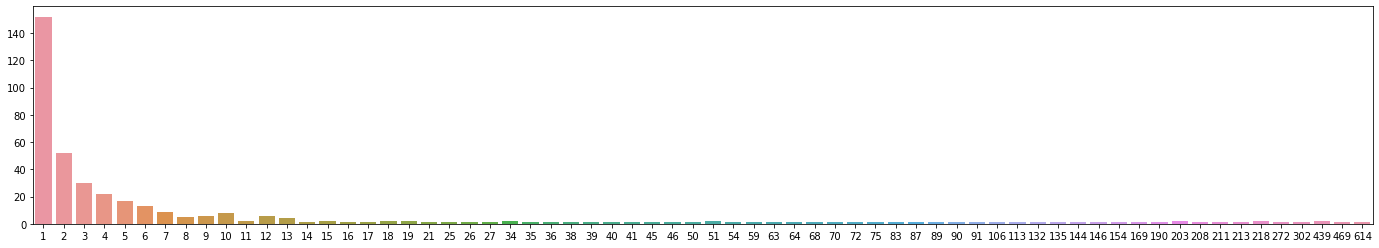

In [46]:
counter_union = dict(Counter(np.sort(np.sum(di_lnc_union.values, axis=1))))
plt.figure(figsize=(24,4))
sns.barplot(list(counter_union.keys()), list(counter_union.values()))

## Only the intersection part is retained
316 diseases, 665 lncRNAs, 3833 associations

In [41]:
di_lnc_intersection = di_lnc_union.loc[:, (np.sum(di_lnc_lnc2Cancer.values, axis=0) > 0 ) & (np.sum(di_lnc_lncRNADisease.values, axis=0) > 0)]
di_lnc_intersection = di_lnc_intersection.loc[np.sum(di_lnc_intersection.values, axis=1) > 0, :]
di_lnc_intersection

,CCAT1-L,H19,ZNF295-AS1,LINC01138,MAPKAPK5-AS1,LINC01554,LINC-PINT,NORAD,ZFAT-AS1,TC0101441,...,RP4-583P15.10,LINC00161,PVT1-5,EF177379,DLEU1,LINC00689,LOC646329,CTD-2020K17.1,TCONS_l2_00020565,CCND2-AS1
DOID:684,0,1,0,1,1,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
DOID:4362,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
DOID:769,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:1612,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
DOID:9256,1,1,0,0,1,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOID:3711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:2392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:1921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOID:235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
di_lnc_intersection.to_csv('data/ours/dataset2/intersection/di_lnc_intersection.csv')

In [50]:
print(np.sum(di_lnc_intersection.values))

3833


F:\anaconda3\envs\dataAnalysis\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

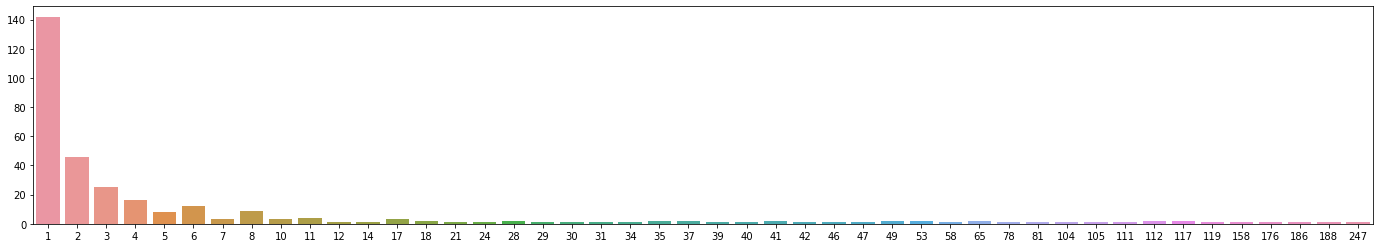

In [49]:
counter_intersection = dict(Counter(np.sort(np.sum(di_lnc_intersection.values, axis=1))))
plt.figure(figsize=(24,4))
sns.barplot(list(counter_intersection.keys()), list(counter_intersection.values()))

# get miRNA nodes

## Dealing with HMDD disease names

### auto

In [55]:
auto_HMDD_diseases = pd.DataFrame(columns=['DOID', 'Name', 'HMDD disease', 'HMDD matching way', 'intermedia'])
for hmdd_di in mi_di_HMDD_v3['disease'].dropna().drop_duplicates():
    # if hmdd_di[-13:] == ' [unspecific]':
    #     hmdd_di = hmdd_di[:-13]
    old_hmdd_di = hmdd_di
    hmdd_di = relo(hmdd_di)
    for doid in DOID_Name_synonym:
        tmp = DOID_Name_synonym[doid]
        if (hmdd_di == tmp['name']):
            auto_HMDD_diseases = auto_HMDD_diseases.append({
                'DOID': doid,
                'Name': HDO_Net.nodes[doid]['name'],
                'HMDD disease': old_hmdd_di,
                'HMDD matching way': 'direct'
            }, ignore_index=True)
        if (hmdd_di in tmp['synonym']):
            auto_HMDD_diseases = auto_HMDD_diseases.append({
                'DOID': doid,
                'Name': HDO_Net.nodes[doid]['name'],
                'HMDD disease': old_hmdd_di,
                'HMDD matching way': 'synonym'
            }, ignore_index=True)
    for meshid in mesh_D:
        tmp = mesh_D[meshid]
        if (hmdd_di == tmp['MeSH Heading']):
            tmp_DO_MeSH = DO_MeSH[DO_MeSH['MeSH ID'] == meshid]
            if not tmp_DO_MeSH.empty:
                for tmp_DO_MeSH_value in tmp_DO_MeSH['DOID'].values:
                    auto_HMDD_diseases = auto_HMDD_diseases.append({
                        'DOID': tmp_DO_MeSH_value,
                        'Name': HDO_Net.nodes[tmp_DO_MeSH_value]['name'],
                        'HMDD disease': old_hmdd_di,
                        'HMDD matching way': 'mesh',
                        'intermedia': mesh_D[meshid]['name']
                    }, ignore_index=True)
        if (hmdd_di in tmp['Entry Terms']):
            tmp_DO_MeSH = DO_MeSH[DO_MeSH['MeSH ID'] == meshid]
            if not tmp_DO_MeSH.empty:
                for tmp_DO_MeSH_value in tmp_DO_MeSH['DOID'].values:
                    auto_HMDD_diseases = auto_HMDD_diseases.append({
                        'DOID': tmp_DO_MeSH_value,
                        'Name': HDO_Net.nodes[tmp_DO_MeSH_value]['name'],
                        'HMDD disease': old_hmdd_di,
                        'HMDD matching way': 'mesh entry',
                        'intermedia': mesh_D[meshid]['name']
                    }, ignore_index=True)
auto_HMDD_diseases

,DOID,Name,HMDD disease,HMDD matching way,intermedia
0,DOID:1040,chronic lymphocytic leukemia,"Leukemia, Lymphocytic, Chronic, B-Cell",synonym,NaN
1,DOID:1040,chronic lymphocytic leukemia,"Leukemia, Lymphocytic, Chronic, B-Cell",mesh,"Leukemia, Lymphocytic, Chronic, B-Cell"
2,DOID:1040,chronic lymphocytic leukemia,"Leukemia, Lymphocytic, Chronic, B-Cell",mesh entry,"Leukemia, Lymphocytic, Chronic, B-Cell"
3,DOID:219,colon cancer,Colon Neoplasms,mesh entry,Colonic Neoplasms
4,DOID:234,colon adenocarcinoma,Colon Neoplasms,mesh entry,Colonic Neoplasms
...,...,...,...,...,...
1425,DOID:0050697,chorioamnionitis,Chorioamnionitis,direct,NaN
1426,DOID:0050697,chorioamnionitis,Chorioamnionitis,mesh,Chorioamnionitis
1427,DOID:4560,non specific chronic endometritis,Non Specific Chronic Endometritis,direct,NaN
1428,DOID:3502,ampulla of Vater adenocarcinoma,"Adenocarcinoma, Ampullary",synonym,NaN


In [56]:
# auto_HMDD_diseases = auto_HMDD_diseases.drop_duplicates(subset=['DOID', 'HMDD disease'])
auto_HMDD_diseases.merge(diseases, on=['DOID', 'Name'], how='right').to_excel('data/ours/dataset2/auto_hmdd_diseases.xlsx')

### manual

In [83]:
manual_HMDD_diseases = pd.read_excel('data/ours/dataset2/manual_hmdd_diseases.xlsx')
manual_HMDD_diseases

,DOID,Name,HMDD disease,HMDD matching way,intermedia,lower disease name
0,DOID:684,hepatocellular carcinoma,"Carcinoma, Hepatocellular",direct,NaN,"('carcinoma', 'hepatocellular')"
1,DOID:684,hepatocellular carcinoma,hepatocellular carcinoma,direct,NaN,"('carcinoma', 'hepatocellular')"
2,DOID:4362,cervical cancer,Cervical Neoplasms,mesh entry,Uterine Cervical Neoplasms,"('cancer', 'cervical')"
3,DOID:769,neuroblastoma,Neuroblastoma,direct,NaN,"('neuroblastoma',)"
4,DOID:1612,breast cancer,Breast Neoplasms,mesh,Breast Neoplasms,"('breast', 'cancer')"
...,...,...,...,...,...,...
384,DOID:3711,bladder adenocarcinoma,NaN,NaN,NaN,"('adenocarcinoma', 'bladder')"
385,DOID:2392,glandular cystitis,NaN,NaN,NaN,"('cystitis', 'glandular')"
386,DOID:1921,Klinefelter syndrome,Hypogonadotropic Hypogonadism,synonym,NaN,"(""klinefelter's"", 'syndrome')"
387,DOID:235,colonic benign neoplasm,Colon Neoplasms,mesh entry,Colonic Neoplasms,"('colonic', 'neoplasms')"


In [93]:
manual_HMDD_diseases = manual_HMDD_diseases.dropna(subset=['HMDD disease'])
for index, row in manual_HMDD_diseases.iterrows():
    # row['lower disease name'] = relo(row['HMDD disease'])
    if row['HMDD disease'] in set(mi_di_HMDD_v3['disease']):
        if pd.isna(row['HMDD matching way']):
            row['HMDD matching way'] = 'manual'
    else:
        print(row['HMDD disease'])
manual_HMDD_diseases.to_excel('data/ours/dataset2/final_hmdd_diseases.xlsx')

### final

In [14]:
final_hmdd_diseases = pd.read_excel('data/ours/dataset2/final_hmdd_diseases.xlsx')
for index, row in final_hmdd_diseases.iterrows():
    row['lower disease name'] = relo(row['HMDD disease'])
hmdd_diseases = final_hmdd_diseases[['DOID', 'HMDD disease', 'lower disease name']]
display(hmdd_diseases)

,DOID,HMDD disease,lower disease name
0,DOID:684,"Carcinoma, Hepatocellular","(carcinoma, hepatocellular)"
1,DOID:684,hepatocellular carcinoma,"(carcinoma, hepatocellular)"
2,DOID:4362,Cervical Neoplasms,"(cervical, neoplasms)"
3,DOID:769,Neuroblastoma,"(neuroblastoma,)"
4,DOID:1612,Breast Neoplasms,"(breast, neoplasms)"
...,...,...,...
286,DOID:0050156,Idiopathic Pulmonary Fibrosis,"(fibrosis, idiopathic, pulmonary)"
287,DOID:127,Leiomyoma,"(leiomyoma,)"
288,DOID:1921,Hypogonadotropic Hypogonadism,"(hypogonadism, hypogonadotropic)"
289,DOID:235,Colon Neoplasms,"(colon, neoplasms)"


## Union
387 diseases, 3832 lncRNAs, 1070 miRNAs; 8033 disease-lncRNA associations, 3215 miRNA-lncRNA associations, 14453 diseaes-miRNA associations.

In [21]:
miRNA_starBase_union = set()
for lncRNA in lncRNAs:
    miRNA_starBase_union = miRNA_starBase_union | set(mi_lnc_starBase[mi_lnc_starBase['lncRNA'] == lncRNA]['miRNA'].values)
print(len(miRNA_starBase_union))

312


In [19]:
miRNA_HMDD_union = set()
for disease in hmdd_diseases['lower disease name'].drop_duplicates():
    miRNA_HMDD_union = miRNA_HMDD_union | set(mi_di_HMDD_v3[mi_di_HMDD_v3['lower disease name'] == disease]['miRNA'].values)
print(len(miRNA_HMDD_union))

1054


In [20]:
print(len(miRNA_starBase_union | miRNA_HMDD_union), len(miRNA_starBase_union & miRNA_HMDD_union))

1070 296


In [26]:
miRNAs_union = miRNA_starBase_union | miRNA_HMDD_union
mi_lnc_union = pd.DataFrame(index=miRNAs_union, columns=lncRNAs)
mi_lnc_starBase_union = mi_lnc_starBase[mi_lnc_starBase['lncRNA'].isin(lncRNAs)]
for miRNA in miRNAs_union:
    tmp_lncRNAs = set(mi_lnc_starBase_union[mi_lnc_starBase_union['miRNA'] == miRNA]['lncRNA'].values)
    mi_lnc_union.loc[miRNA, list(tmp_lncRNAs)] = 1
mi_lnc_union = mi_lnc_union.fillna(0)

In [29]:
mi_lnc_union.to_csv('data/ours/dataset2/union/mi_lnc_union.csv')

In [28]:
np.sum(mi_lnc_union.values)

3215

In [36]:
di_mi_union = pd.DataFrame(index=diseases['DOID'].values, columns=miRNAs_union)
mi_di_HMDD_union = mi_di_HMDD_v3[mi_di_HMDD_v3['miRNA'].isin(miRNAs_union)]
for idx, disease in hmdd_diseases.iterrows():
    tmp_miRNAs = set(mi_di_HMDD_union[mi_di_HMDD_union['lower disease name'] == disease['lower disease name']]['miRNA'].values)
    di_mi_union.loc[disease['DOID'], list(tmp_miRNAs)] = 1
di_mi_union = di_mi_union.fillna(0)

In [39]:
di_mi_union.to_csv('data/ours/dataset2/union/di_mi_union.csv')

In [38]:
np.sum(di_mi_union.values)

14453

## Intersection
316 diseases, 665 lncRNAs, 295 miRNAs; 3833 disease-lncRNA associations, 2108 miRNA-lncRNA associations, 8540 diseaes-miRNA associations.

In [43]:
miRNA_starBase_intersection = set()
for lncRNA in di_lnc_intersection.columns:
    miRNA_starBase_intersection = miRNA_starBase_intersection | set(mi_lnc_starBase[mi_lnc_starBase['lncRNA'] == lncRNA]['miRNA'].values)
print(len(miRNA_starBase_intersection))

311


In [44]:
miRNA_HMDD_intersection = set()
hmdd_diseases_intersection = hmdd_diseases[hmdd_diseases['DOID'].isin(di_lnc_intersection.index)]
for disease in hmdd_diseases_intersection['lower disease name'].drop_duplicates():
    miRNA_HMDD_intersection = miRNA_HMDD_intersection | set(mi_di_HMDD_v3[mi_di_HMDD_v3['lower disease name'] == disease]['miRNA'].values)
print(len(miRNA_HMDD_intersection))

1034


In [45]:
print(len(miRNA_starBase_intersection | miRNA_HMDD_intersection), len(miRNA_starBase_intersection & miRNA_HMDD_intersection))

1050 295


In [46]:
miRNAs_intersection = miRNA_starBase_intersection & miRNA_HMDD_intersection
mi_lnc_intersection = pd.DataFrame(index=miRNAs_intersection, columns=di_lnc_intersection.columns)
mi_lnc_starBase_intersection = mi_lnc_starBase[mi_lnc_starBase['lncRNA'].isin(di_lnc_intersection.columns)]
for miRNA in miRNAs_intersection:
    tmp_lncRNAs = set(mi_lnc_starBase_intersection[mi_lnc_starBase_intersection['miRNA'] == miRNA]['lncRNA'].values)
    mi_lnc_intersection.loc[miRNA, list(tmp_lncRNAs)] = 1
mi_lnc_intersection = mi_lnc_intersection.fillna(0)

In [51]:
mi_lnc_intersection.to_csv('data/ours/dataset2/intersection/mi_lnc_intersection.csv')

In [48]:
np.sum(mi_lnc_intersection.values)

2108

In [52]:
di_mi_intersection = pd.DataFrame(index=di_lnc_intersection.index, columns=miRNAs_intersection)
mi_di_HMDD_intersection = mi_di_HMDD_v3[mi_di_HMDD_v3['miRNA'].isin(miRNAs_intersection)]
hmdd_diseases_intersection = hmdd_diseases[hmdd_diseases['DOID'].isin(di_lnc_intersection.index)]
for idx, disease in hmdd_diseases_intersection.iterrows():
    tmp_miRNAs = set(mi_di_HMDD_intersection[mi_di_HMDD_intersection['lower disease name'] == disease['lower disease name']]['miRNA'].values)
    di_mi_intersection.loc[disease['DOID'], list(tmp_miRNAs)] = 1
di_mi_intersection = di_mi_intersection.fillna(0)

In [55]:
di_mi_intersection.to_csv('data/ours/dataset2/intersection/di_mi_intersection.csv')

In [54]:
np.sum(di_mi_intersection.values)

8540